## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [12]:
%pip install requests pandas seaborn duckdb matplotlib

import os
import requests
import zipfile
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Load data

In [13]:
url = "https://zenodo.org/records/17781640/files/hra-pop-v1.0-qc.zip?download=1"

folder_path = "data"
os.makedirs(folder_path, exist_ok=True)

zip_name = "hra-pop-v1.0-qc.zip"
file_path = f"{folder_path}/{zip_name}"

if not os.path.exists(file_path):
    print("Downloading…")
    r = requests.get(url, allow_redirects=True)
    with open(file_path, "wb") as f:
        f.write(r.content)
    print(f"File downloaded and saved at {file_path}")
else:
    print(f"File already exists at {file_path}")

File already exists at data/hra-pop-v1.0-qc.zip


In [14]:
def unzip_if_needed(zip_path: str, extract_dir: str) -> None:
    """Unzip a ZIP file only if it hasn't been extracted yet."""
    if os.path.exists(extract_dir) and os.listdir(extract_dir):
        print(f"⚙️ Already unzipped — skipping extraction: {extract_dir}")
        return

    print(f"📦 Extracting {zip_path} ...")
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Files extracted to: {extract_dir}")



zip_path = "data/hra-pop-v1.0-qc.zip"
extract_dir = "data/unzipped"
unzip_if_needed(zip_path, extract_dir)

⚙️ Already unzipped — skipping extraction: data/unzipped


In [15]:
"""
D CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );
D .schema qc
CREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);
"""

"\nD CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );\nD .schema qc\nCREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);\n"

In [16]:
data_dir = "data/unzipped"

# 1. Create the table from JSON files
query = f"""
CREATE OR REPLACE TABLE qc AS
WITH qc_data AS (
    SELECT
        *,
        regexp_extract(filename, '.*/qc/([^/]+)/qc_results/.*', 1) AS folder_name
    FROM read_json('{data_dir}/qc/*/qc_results/qc_summary.json',
                   union_by_name = true,
                   filename = true)
),
datasets AS (
    SELECT
        regexp_extract(filename, '.*/qc/([^/]+)/dataset.json', 1) AS folder_name,
        dataset_id
    FROM read_json('{data_dir}/qc/*/dataset.json',
                   union_by_name = true,
                   filename = true)
)
SELECT 
    q.*,
    d.dataset_id
FROM qc_data q
LEFT JOIN datasets d USING (folder_name);
"""

# Run the query
duckdb.sql(query)

# ✅ Load the table into a Pandas DataFrame
df_qc = duckdb.sql("SELECT * FROM qc").df()

# 2. Export results to CSV
duckdb.sql(
    f"""
COPY qc TO '{data_dir}/cell-instances.csv.gz' (FORMAT CSV, HEADER, COMPRESSION GZIP);
"""
)

# 3. Optionally show a preview
print("\n🔍 Preview:")
duckdb.sql("SELECT * FROM qc LIMIT 10;").show()

# 4. Verify DataFrame content
print("\n📊 DataFrame loaded with shape:", df_qc.shape)
print(df_qc.head())


🔍 Preview:
┌────────────────────────────────────────────────────────────────┬─────────────┬───────────────────┬─────────────────────┬────────────────────────┬───────────────────┬─────────────────────────────────┬─────────────────────────────────┬────────────────────┬──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────────────────────┐
│                           input_file                           │ total_cells │ low_quality_cells │ percent_low_quality │ mean_n_genes_by_counts │ mean_total_counts │ mean_pct_counts_in_top_20_genes │ mean_pct_counts_in_top_50_genes │ mean_pct_counts_mt │ mean_pct_counts_ribo │                                

In [17]:
df_qc

,input_file,total_cells,low_quality_cells,percent_low_quality,mean_n_genes_by_counts,mean_total_counts,mean_pct_counts_in_top_20_genes,mean_pct_counts_in_top_50_genes,mean_pct_counts_mt,mean_pct_counts_ribo,thresholds,files,filename,folder_name,dataset_id
0,/var/lib/cwl/stg49a6c9e7-0bc2-4068-9acf-196949...,326,0,0.00,558.472,1494.890,6.179,13.855,0.0,0.004,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/GTEX-15EOM-5003-SM-G64IH/qc_r...,GTEX-15EOM-5003-SM-G64IH,https://doi.org/10.1126/science.abl4290#GTEX-1...
1,/var/lib/cwl/stg294542bd-83d6-4606-bc6d-54861c...,26251,18030,68.68,169.725,139.465,45.042,68.418,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM242.HNLH.466/qc_results/qc...,HBM242.HNLH.466,https://entity.api.hubmapconsortium.org/entiti...
2,/var/lib/cwl/stg1ef06836-1537-4f22-8ec1-c39538...,1783,21,1.18,3770.721,8169.177,10.191,15.985,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM259.DZXX.383/qc_results/qc...,HBM259.DZXX.383,https://entity.api.hubmapconsortium.org/entiti...
3,/var/lib/cwl/stgfadc554a-9fa8-44b7-a3c8-0310a9...,53121,46692,87.90,66.144,65.228,84.874,89.230,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM284.MNHF.223/qc_results/qc...,HBM284.MNHF.223,https://entity.api.hubmapconsortium.org/entiti...
4,/var/lib/cwl/stg13c1fc0a-cc2a-4c65-aed8-a439bd...,19338,7393,38.23,506.567,566.038,32.816,48.662,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM333.XMCV.992/qc_results/qc...,HBM333.XMCV.992,https://entity.api.hubmapconsortium.org/entiti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,/var/lib/cwl/stgecfc17e3-f3e8-4087-8166-6c1454...,2744,0,0.00,1905.866,1018.227,4.959,9.962,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
554,/var/lib/cwl/stg0872f4a4-c338-4297-9871-3b0881...,8944,0,0.00,1608.030,946.270,5.374,10.753,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
555,/var/lib/cwl/stgaee60907-44fe-463b-a4dd-ac8b65...,5545,0,0.00,2252.554,2733.390,3.404,7.559,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
556,/var/lib/cwl/stg55b8f288-9d82-4e9e-a9fc-b77097...,2296,4,0.17,2763.647,2597.972,3.634,7.405,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...


In [18]:
df_qc.columns

Index(['input_file', 'total_cells', 'low_quality_cells', 'percent_low_quality',
       'mean_n_genes_by_counts', 'mean_total_counts',
       'mean_pct_counts_in_top_20_genes', 'mean_pct_counts_in_top_50_genes',
       'mean_pct_counts_mt', 'mean_pct_counts_ribo', 'thresholds', 'files',
       'filename', 'folder_name', 'dataset_id'],
      dtype='object')

## Preprocess before visualizing

In [19]:
# Load Sankey CSV to add organ name
df_sankey = pd.read_csv(
    "https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/main/output-data/v1.0/reports/universe-ad-hoc/sankey.csv"
)[["organ_name", "dataset_id", "portal"]]

df_sankey

/var/folders/x7/ttglg94d4g500ypbdkw3__nw0000gq/T/ipykernel_38497/3690142819.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sankey = pd.read_csv(


,organ_name,dataset_id,portal
0,small intestine,hhttps://api.cellxgene.cziscience.com/dp/v1/co...,HCA
1,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
2,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
3,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
4,mesenteric lymph node,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...,HRA
...,...,...,...
22189,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22190,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22191,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22192,left kidney,https://zenodo.org/records/7653239#Donor1_Tiss...,KPMP


In [20]:
df_merged = df_qc.merge(df_sankey, on="dataset_id", how="inner")

## Get mean, median, standard deviation

In [21]:
qc_table_merged = (
    df_merged.groupby("organ_name")
    .agg(
        {
            # columns with mean, median, std
            "mean_pct_counts_ribo": ["mean", "median", "std"],
            "mean_pct_counts_mt": ["mean", "median", "std"],
            # columns where you want ONLY mean
            "mean_n_genes_by_counts": ["mean"],
            "mean_total_counts": ["mean"],
            "mean_pct_counts_in_top_20_genes": ["mean"],
            "mean_pct_counts_in_top_50_genes": ["mean"],
        }
    )
    .reset_index()
)

# Flatten columns
qc_table_merged.columns = [
    (
        "Organ name"
        if col[0] == "organ_name"
        else (
            f"{col[0]}"
            if col[1] == "mean"
            and col[0].startswith("mean_")
            and col[0] not in ["mean_pct_counts_ribo", "mean_pct_counts_mt"]
            else f"{col[0]}_{col[1]}"
        )
    )
    for col in qc_table_merged.columns
]

# Rename to readable names
qc_table_merged = qc_table_merged.rename(
    columns={
        # ribosomal stats
        "mean_pct_counts_ribo_mean": "Mean % ribosomal genes",
        "mean_pct_counts_ribo_median": "Median % ribosomal genes",
        "mean_pct_counts_ribo_std": "SD % ribosomal genes",
        # mitochondrial stats
        "mean_pct_counts_mt_mean": "Mean % mitochondrial genes",
        "mean_pct_counts_mt_median": "Median % mitochondrial genes",
        "mean_pct_counts_mt_std": "SD % mitochondrial genes",
        # mean-only columns
        "mean_n_genes_by_counts": "Mean number of genes with positive counts",
        "mean_total_counts": "Mean total number of genes",
        "mean_pct_counts_in_top_20_genes": "% of counts for 20 most expressed genes",
        "mean_pct_counts_in_top_50_genes": "% of counts for 50 most expressed genes",
    }
)

# Capitalize organ names
qc_table_merged["Organ name"] = qc_table_merged["Organ name"].str.capitalize()

# Round final table
qc_table_merged = qc_table_merged.round(6)

qc_table_merged

,Organ name,Mean % ribosomal genes,Median % ribosomal genes,SD % ribosomal genes,Mean % mitochondrial genes,Median % mitochondrial genes,SD % mitochondrial genes,Mean number of genes with positive counts,Mean total number of genes,% of counts for 20 most expressed genes,% of counts for 50 most expressed genes
0,Set of lactiferous glands in left breast,0.000000,0.0000,0.000000,0.0,0.0,0.0,3346.585000,3387.702000,2.567000,5.686000
1,Set of lactiferous glands in right breast,0.001333,0.0010,0.000577,0.0,0.0,0.0,658.067333,1706.838000,5.100333,11.702000
2,Heart,0.000045,0.0000,0.000282,0.0,0.0,0.0,1154.918946,1114.928000,20.405297,26.367613
3,Large intestine,0.000000,0.0000,0.000000,0.0,0.0,0.0,1702.504234,2855.922383,24.662426,32.965426
4,Left kidney,0.000000,0.0000,0.000000,0.0,0.0,0.0,1057.325196,2077.369989,34.451478,46.355250
5,Left ureter,0.000000,0.0000,0.000000,0.0,0.0,0.0,1791.867231,3225.290462,14.325231,21.706615
6,Liver,0.000000,0.0000,0.000000,0.0,0.0,0.0,1431.246000,2491.348500,18.289000,26.159500
7,Male reproductive system,0.001167,0.0015,0.000983,0.0,0.0,0.0,1763.145333,2469.973333,3.874167,8.672333
8,Pancreas,0.000000,0.0000,0.000000,0.0,0.0,0.0,3755.175000,3327.740000,2.983000,6.002000
9,Respiratory system,0.000087,0.0000,0.000565,0.0,0.0,0.0,1344.932522,3095.898826,30.152576,39.994685


In [22]:
qc_table_merged.to_csv("output/qc_table.csv", index=False, float_format="%.5f")

# Scatter graph with gene counts

In [25]:
df_merged.columns

Index(['input_file', 'total_cells', 'low_quality_cells', 'percent_low_quality',
       'mean_n_genes_by_counts', 'mean_total_counts',
       'mean_pct_counts_in_top_20_genes', 'mean_pct_counts_in_top_50_genes',
       'mean_pct_counts_mt', 'mean_pct_counts_ribo', 'thresholds', 'files',
       'filename', 'folder_name', 'dataset_id', 'organ_name', 'portal'],
      dtype='object')

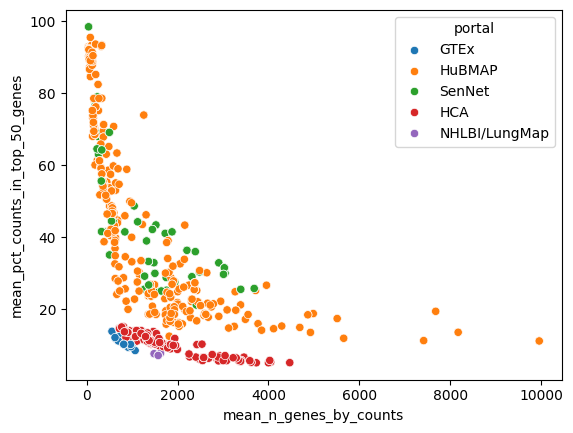

In [36]:
sns.scatterplot(
    data=df_merged,
    x="mean_n_genes_by_counts",
    y="mean_pct_counts_in_top_50_genes",
    hue="portal",
)
plt.show()

# Scatter graph with ribo vs mito per dataset

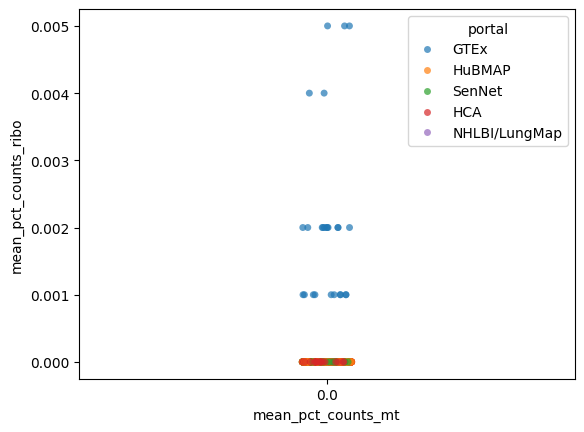

In [35]:
sns.stripplot(data=df_merged, x="mean_pct_counts_mt", y="mean_pct_counts_ribo", hue="portal", jitter=0.05, alpha=0.7)
plt.show()